In [1]:
import base
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rushd as rd
import scipy.stats
import seaborn as sns

# enables concurrent editing of base.py
from importlib import reload
reload(base)

sns.set_style('ticks')
sns.set_context('talk',rc={'font.family': 'sans-serif', 'font.sans-serif':['Helvetica Neue']})

/home/christopher/cloud/gallowaylab/instruments/data/attune/chris/2024.06.02-exp95-lenti-miR-iFFL/export/plate1_293T_P9_metadata.yaml


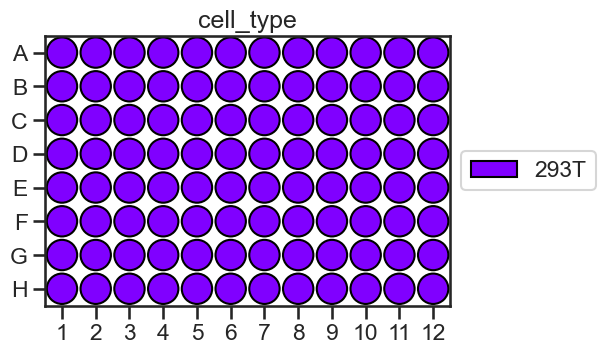

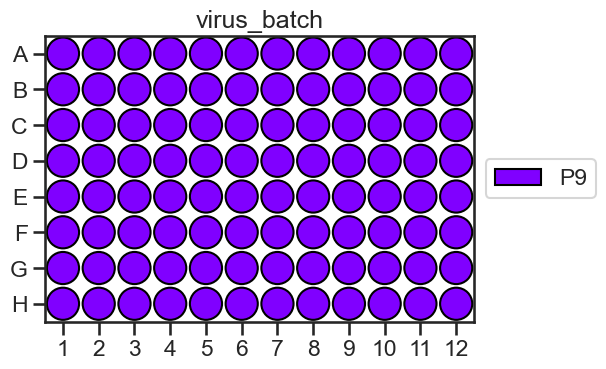

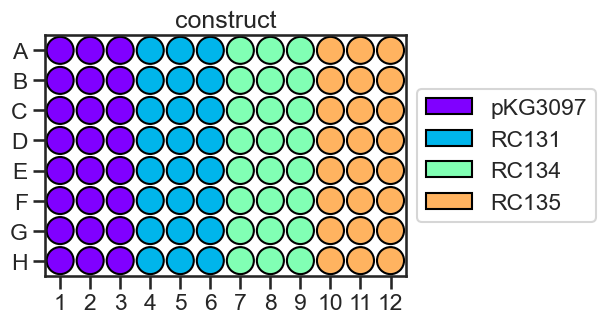

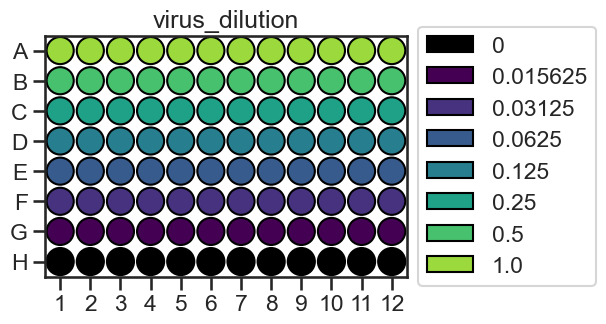

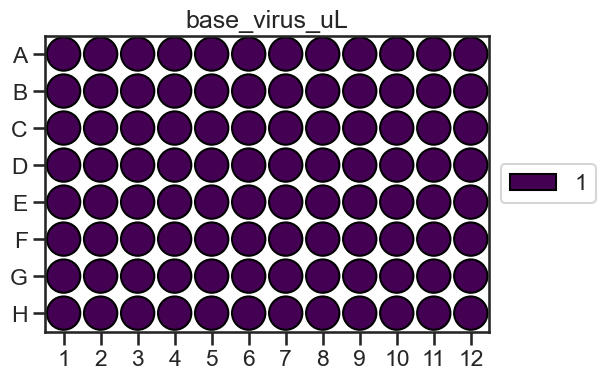

/home/christopher/cloud/gallowaylab/instruments/data/attune/chris/2024.06.02-exp95-lenti-miR-iFFL/export/plate4_MEF2A_P9_metadata.yaml


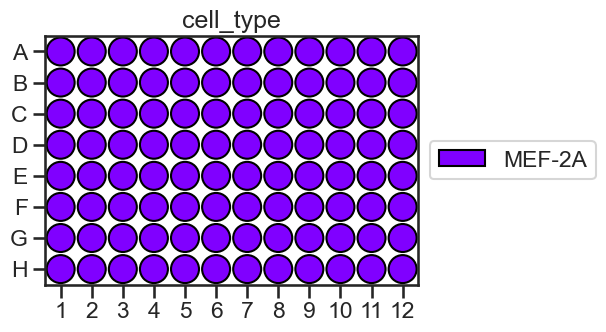

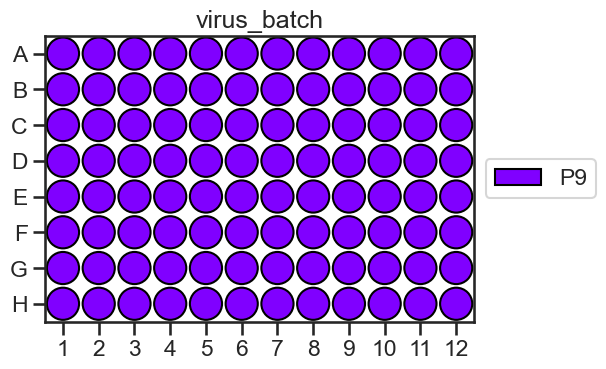

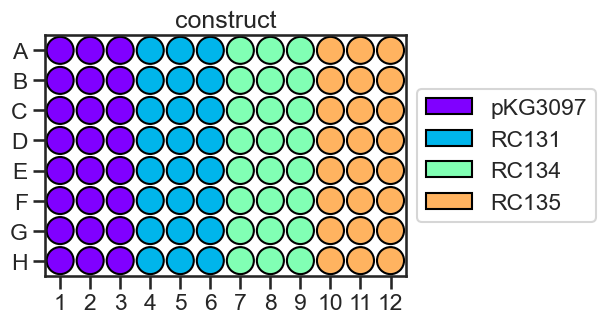

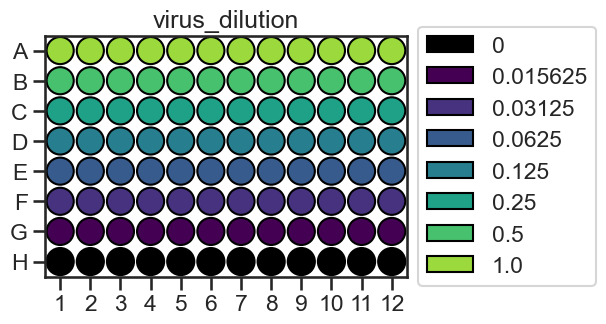

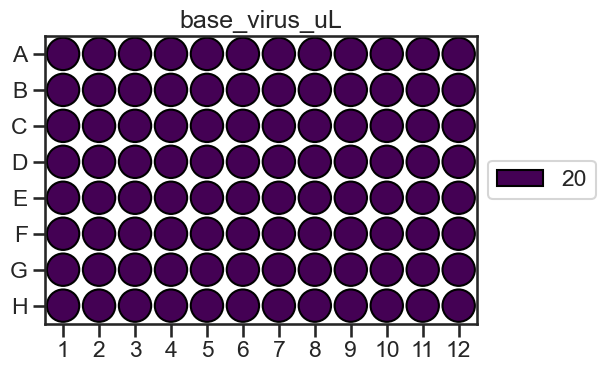

{'base_virus_uL', 'cell_type', 'construct', 'virus_batch', 'virus_dilution'}

In [2]:
base_path = rd.datadir/'instruments'/'data'/'attune'/'chris'/'2024.06.02-exp95-lenti-miR-iFFL'/'export'

plates = pd.DataFrame({
    'data_path': [base_path/'plate1_293T_P9', base_path/'plate4_MEF2A_P9'],
    'yaml_path': [base_path/'plate1_293T_P9_metadata.yaml', base_path/'plate4_MEF2A_P9_metadata.yaml']
})

output_path = rd.rootdir/'output'/'lenti-exp95'
cache_path = output_path/'data.gzip'

metadata_keys = set()
for p in plates['yaml_path'].unique():
    print(p)
    rd.plot.plot_well_metadata(p)
    metadata_keys.update(rd.flow.load_well_metadata(p).keys())
display(metadata_keys)

In [3]:
# Load data
data = pd.DataFrame()
if cache_path.is_file(): data = pd.read_parquet(cache_path)
else: 
    channel_list = ['mCherry-A','FSC-A','SSC-A','mGL-A']
    data = rd.flow.load_groups_with_metadata(plates, columns=channel_list)

    # Remove negative channel values
    for c in channel_list: data = data[data[c]>0]
    
    data.to_parquet(rd.outfile(cache_path))
# Create dicts to specify colors/markers
metadata = base.get_metadata(rd.datadir/'projects'/'miR-iFFL'/'plasmids'/'construct-metadata.xlsx')
metadata['TS'] = metadata['ts_kind']
metadata_dict = metadata.set_index('construct').to_dict('dict')
construct_palette = metadata_dict['color']
construct_markers = metadata_dict['markers']
display(data)

,cell_type,virus_batch,construct,virus_dilution,base_virus_uL,well,population,FSC-A,SSC-A,mGL-A,mCherry-A
0,293T,P9,RC135,1.0,1,A10,Single Cells,494015,133395,16058,621
3,293T,P9,RC135,1.0,1,A10,Single Cells,183254,100413,7498,202
4,293T,P9,RC135,1.0,1,A10,Single Cells,328091,192474,58,10
6,293T,P9,RC135,1.0,1,A10,Single Cells,186169,128884,38,33
9,293T,P9,RC135,1.0,1,A10,Single Cells,313190,353505,1810,963
...,...,...,...,...,...,...,...,...,...,...,...
9024271,MEF-2A,P9,RC134,0.0,20,H9,Single Cells,444010,143025,74,57
9024273,MEF-2A,P9,RC134,0.0,20,H9,Single Cells,320126,360625,145,20
9024277,MEF-2A,P9,RC134,0.0,20,H9,Single Cells,144324,142356,3,57
9024280,MEF-2A,P9,RC134,0.0,20,H9,Single Cells,278005,123792,51,17


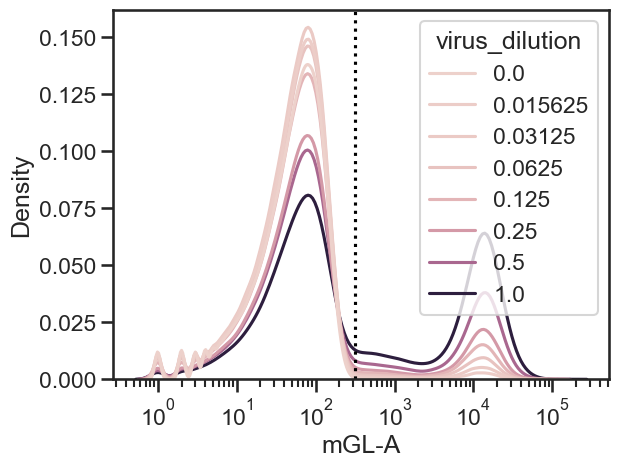

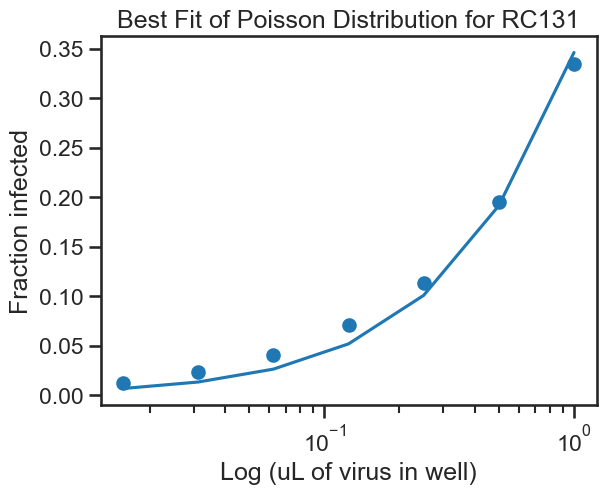

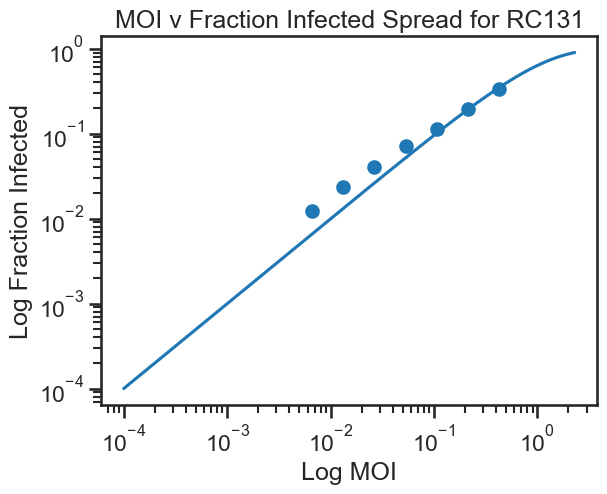

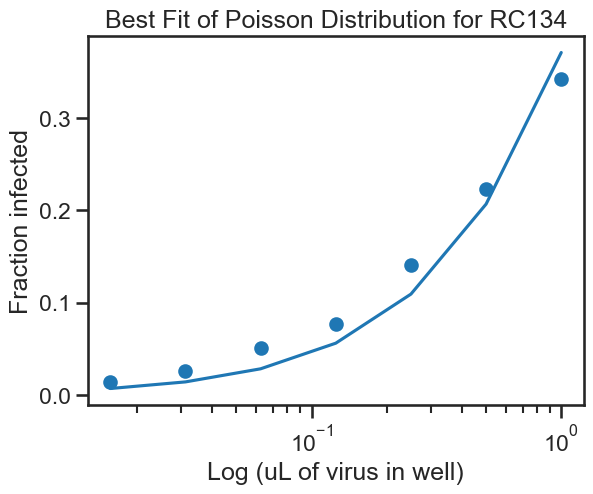

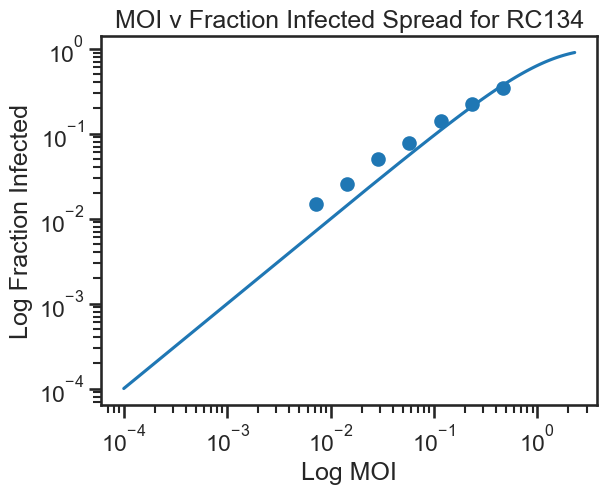

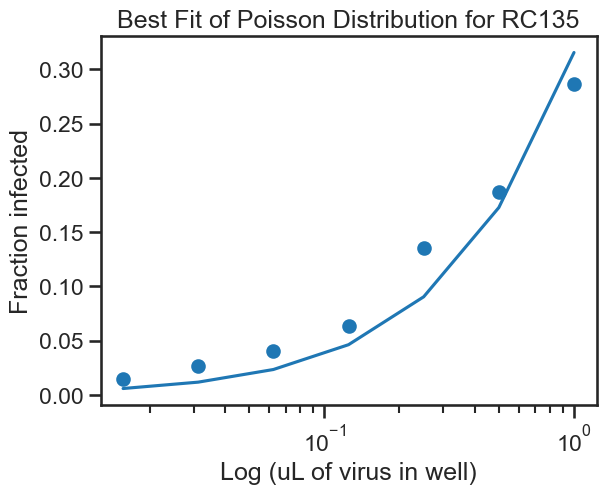

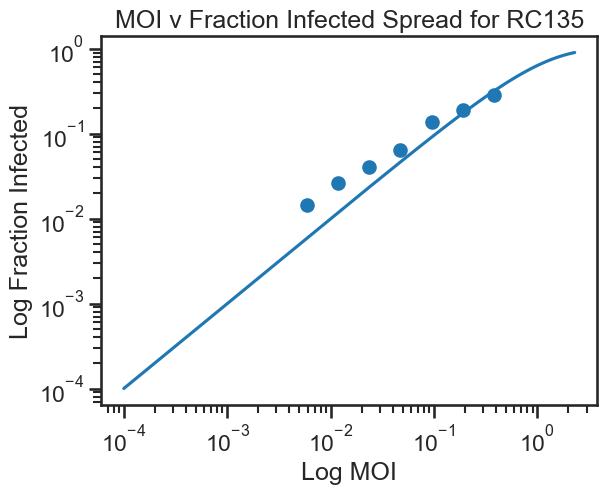

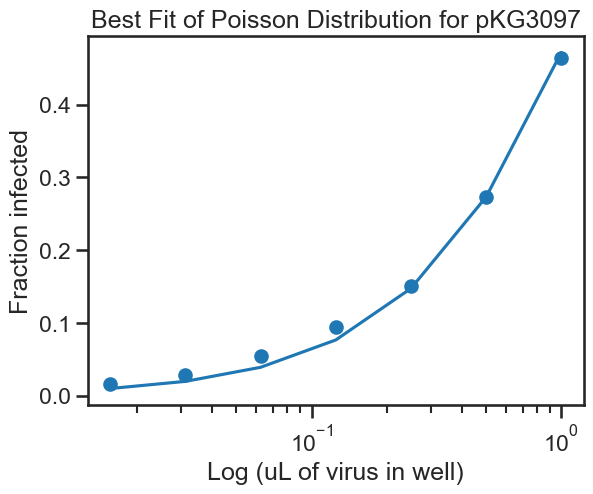

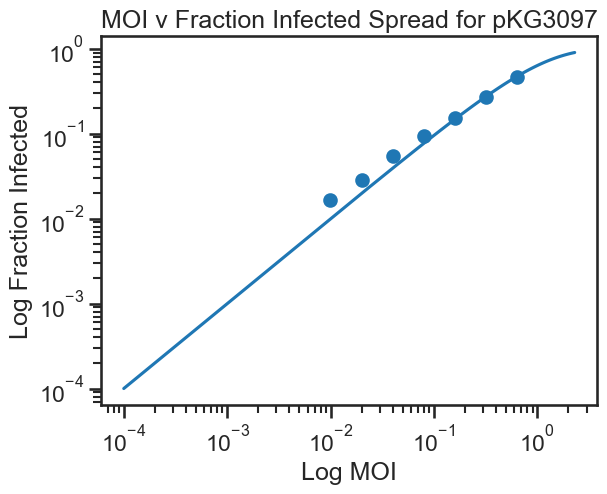

,replicate,starting_cell_count,tui_ratio_per_vol,moi,titer_in_uL
condition,,,,,
RC131,1.0,20000.0,7.0,0.424855,8497.097528
RC134,1.0,20000.0,7.0,0.463633,9272.651089
RC135,1.0,20000.0,7.0,0.379157,7583.131474
pKG3097,1.0,20000.0,7.0,0.637900,12757.990822


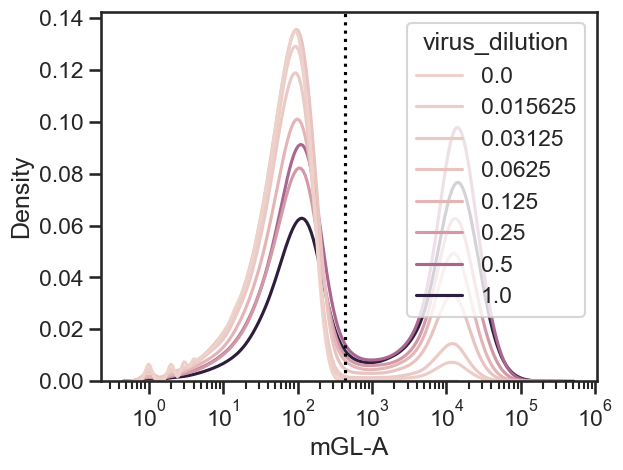

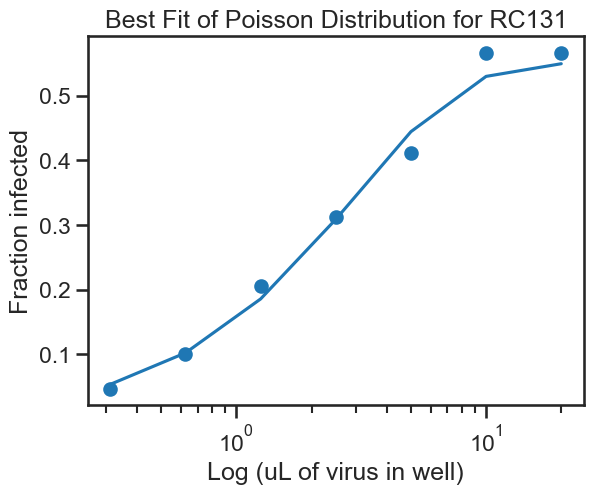

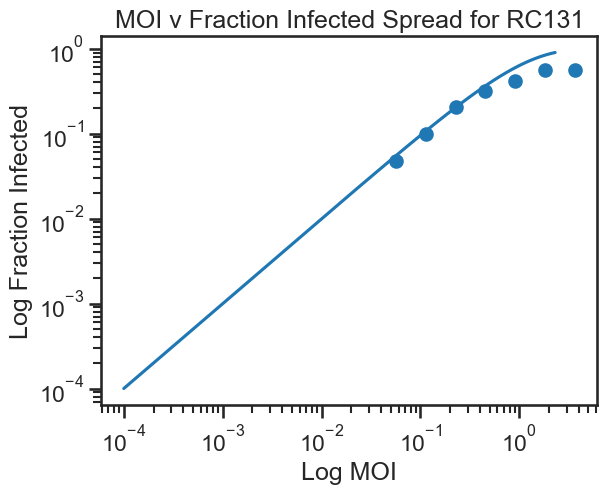

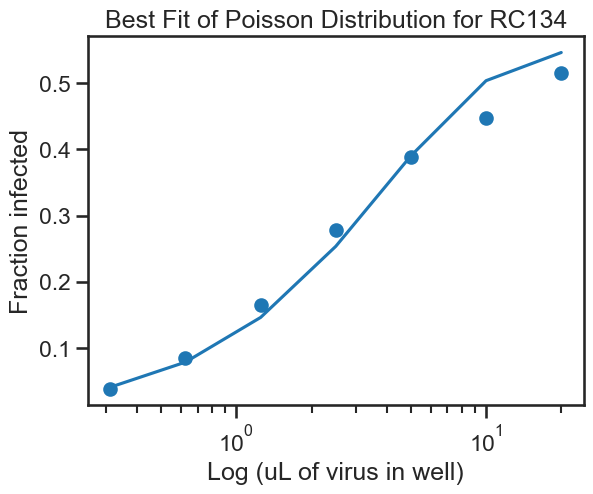

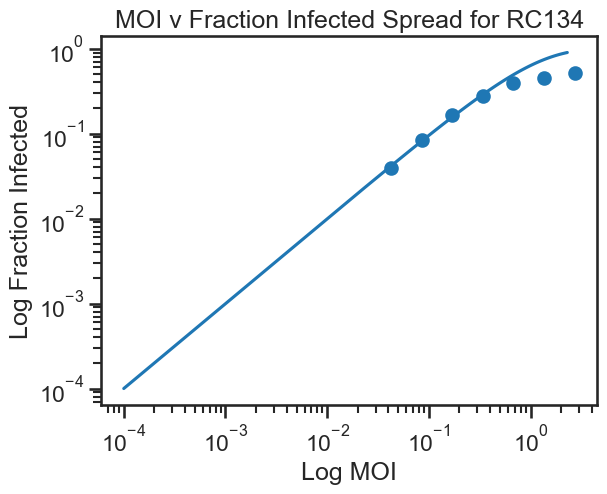

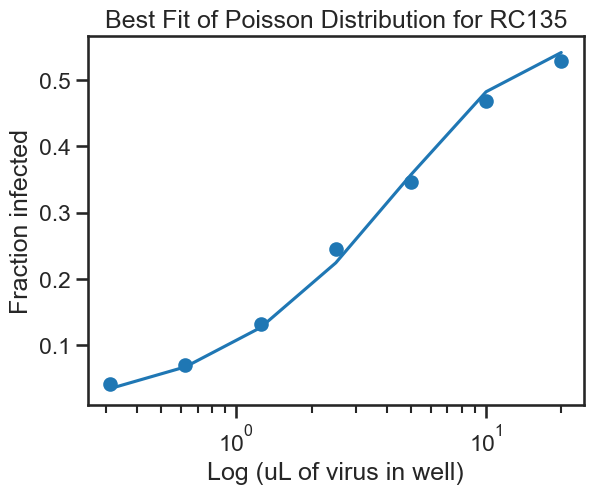

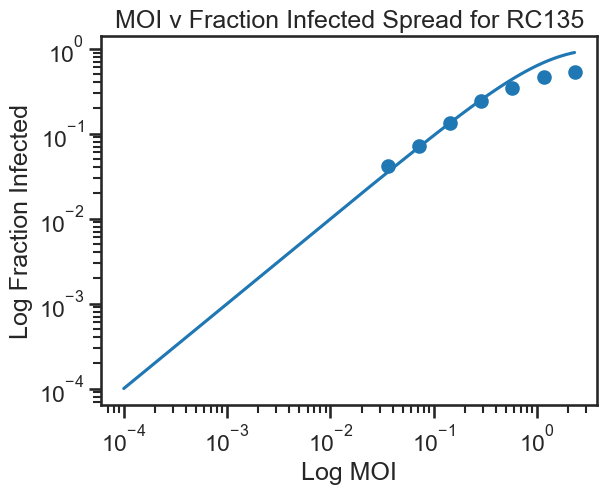

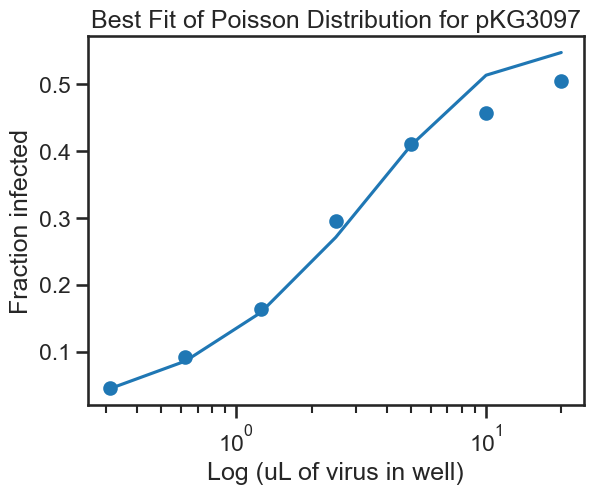

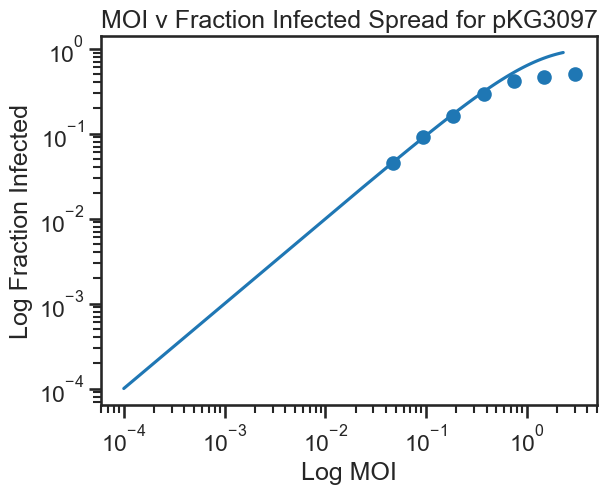

,replicate,starting_cell_count,tui_ratio_per_vol,moi,titer_in_uL
condition,,,,,
RC131,1.0,20000.0,7.0,0.329829,6596.571650
RC134,1.0,20000.0,7.0,0.247181,4943.613015
RC135,1.0,20000.0,7.0,0.209818,4196.352733
pKG3097,1.0,20000.0,7.0,0.271646,5432.911792


In [4]:
for cell_type, cell_count, scale_factor in zip(['293T', 'MEF-2A'], [20000, 20000], [1.0, 0.55]):
    mGL_gate = data[(data.cell_type == cell_type) & (data.virus_dilution == 0.0)]['mGL-A'].quantile(0.9999)
    sns.kdeplot(data[data.cell_type == cell_type], x='mGL-A', hue='virus_dilution', log_scale=True)
    plt.axvline(mGL_gate, color='k', ls=':')
    plt.show()

    moi_df = data[(data.cell_type == cell_type) & (data.virus_dilution != 0.0)].copy()
    moi_df['condition'] = moi_df.construct
    moi_df['replicate'] = 1
    moi_df['starting_cell_count'] = cell_count
    moi_df['scaling'] = moi_df.virus_dilution
    moi_df['max_virus'] = moi_df.base_virus_uL
    display(rd.flow.moi(moi_df, 'mGL-A', mGL_gate, scale_factor=scale_factor))

## Summary
Virus was made at 6-well scale, with each 6-well being resuspended into 200 uL.

#### Seeding
- MEFs: 10k cells seeded the day before. Likely divide to 20k
- 293Ts: 20k cells seeded day-of.

#### Transduction
- 293Ts: added virus to media when seeding.
- MEFs: added virus on top of adhered MEFs, spinfected (1500xg, 37C, 30 minutes)

#### Viral titer per uL
- This is a titer of roughly ~8000-9000 IUs per uL for the 293Ts, and ~4000 IUs per uL for the MEFs.

#### Sanity check MOI
- For the 293Ts, we see about ~10% infection of 20k cells at 0.2 uL of virus added. This matches: 0.2 uL would be ~2000 IUs.
- For the MEFs, we see about ~10% infection of 20k cells (roughly 20% rescaled, due to "uninfectable cells") at 1 uL of virus added. This also lines up

### Application to scale-up
The 10 cm dishes has 5.9x higher surface area. This means we're expecting 47,200 IUs / uL for the 293T case and 23,600 IUs / uL for the MEFs + spinfection.